In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from euler_self_torch import euler_self_tlist

# Oscillator with controller

In [3]:
# Define true ODE
class odeModel_oscillator(nn.Module):
    def __init__(self):
        self.A = torch.tensor([[0, 1],[-1, -0.1]])

    def forward(self, t, y):
        return torch.mm(y, self.A)

In [97]:
# Define true ODE
class odeModel_oscillator_control(nn.Module):

    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 1),
#             nn.Tanh(),
# #             nn.Linear(50, 200),
# #             nn.Tanh(),
# #             nn.Linear(200, 50),
# #             nn.Tanh(),
#             nn.Linear(100, 1),
        )
        
        self.A = torch.tensor([[0, 1],[-1, -0.1]])

    def forward(self, t_grid, y):
        con = self.net(y)
        free = torch.mm(y, self.A)
        con = torch.cat([torch.zeros(con.shape),con], dim=1)
        dy = free + con
        return dy

In [146]:
# Define true ODE
class odeModel_oscillator_control(nn.Module):

    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 1),
#             nn.Tanh(),
# #             nn.Linear(50, 200),
# #             nn.Tanh(),
# #             nn.Linear(200, 50),
# #             nn.Tanh(),
#             nn.Linear(100, 1),
        )
        
        self.A = torch.tensor([[0, 1],[-1, -0.1]])
        self.k = torch.tensor([[0,0],[-24.5025,-10.0]])

    def forward(self, t_grid, y):
        con = self.net(y)
        free = torch.mm(y, self.A)
        con = torch.cat([torch.zeros(con.shape),con], dim=1)
        con = torch.mm(y,self.k)
        dy = free + con
        return dy

In [133]:
(-9.9**2+4)/4

-23.5025

In [138]:
A = np.array([[0, 1],[-1, -0.1]])
k = np.array([[0,0],[-24.5025,-10.0]])
Ak = A+k

In [139]:
np.linalg.eig(Ak)

(array([-5.05+6.78800641e-08j, -5.05-6.78800641e-08j]),
 array([[-0.19424801-2.61100344e-09j, -0.19424801+2.61100344e-09j],
        [ 0.98095245+0.00000000e+00j,  0.98095245-0.00000000e+00j]]))

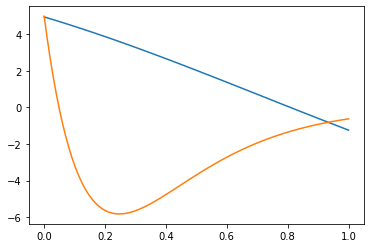

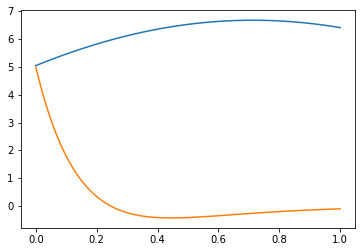

In [156]:
time_steps = 100
t_grid = np.linspace(0, 1, time_steps)
y0_free = torch.tensor([[5., 5.]])

# Run forward evaluation
trajectory = euler_self_tlist(odeModel_oscillator_control(), y0_free, t_grid, 1e-4)
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-2)

plt.plot(t_grid, free_trajectory[:,0,0].detach().numpy(), t_grid, trajectory[:,0,0].detach().numpy())
plt.show()
plt.plot(t_grid, free_trajectory[:,0,1].detach().numpy(), t_grid, trajectory[:,0,1].detach().numpy())
plt.show()

In [98]:
def get_batch(batch_size):
    return torch.rand(batch_size, 2).add_(-0.5).mul_(30)

Iter 0000 | Total Loss 4.511572


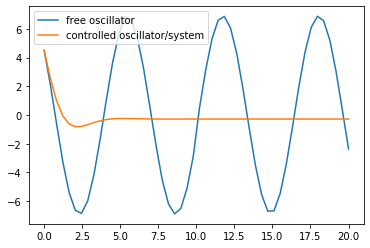

Iter 0400 | Total Loss 2.374602


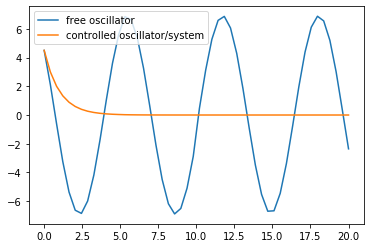

Iter 0800 | Total Loss 2.308312


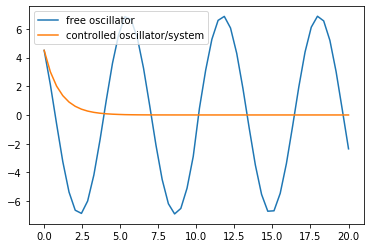

Iter 1200 | Total Loss 2.647964


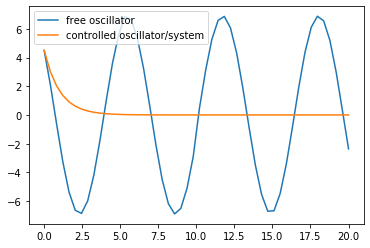

Iter 1600 | Total Loss 2.440563


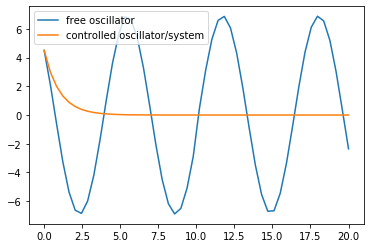

66.86232876777649

In [103]:
# Set up parameters
y0_free = torch.tensor([[5., 5.]])
time_steps = 50
t_grid = np.linspace(0, 20, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-1)

# Initialise new instance of the model
# model = odeModel_oscillator_control()
optimizer = optim.RMSprop(model.parameters(), lr=5e-2)


batch_size = 500
niters = 2000
test_freq = 400
ii = 0
loss_history = []


import time
start_time = time.time()

# Run simulation niters times, updating parameters on each iteration
for itr in range(niters):
    optimizer.zero_grad()  # the gradients accumulate during backpropagation, so one needs to reset them for each batch
    batch_y0 = get_batch(batch_size)  # get random initial condition

    pred_y = euler_self_tlist(model, batch_y0, t_grid, 1e-1)  # solve forward
    loss = torch.mean(pred_y**2)
    loss.backward()  # performs backprop
    optimizer.step()  # performs an update step using the gradients computed in backward()
    
    loss_history.append(loss.item())    
    
    if itr % test_freq == 0:
#         with torch.no_grad():
            pred_y = euler_self_tlist(model, y0_free, t_grid, 1e-1)
#             loss = torch.mean(pred_y**2)
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            
            plt.plot(t_grid, free_trajectory[:, 0, 0].detach().numpy(), t_grid, pred_y[:, 0, 0].detach().numpy())
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()
        
            ii += 1

end_time = time.time()
end_time-start_time

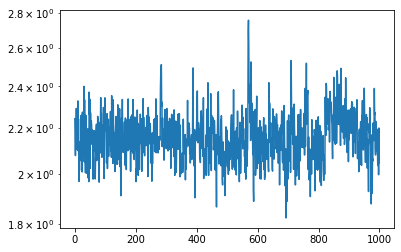

In [88]:
plt.plot(loss_history)
plt.yscale("log")

In [82]:
np.mean(loss_history[-500:])

2.596609028339386

In [108]:
for param in model.parameters():
  print(param.data)

tensor([[ 5.5390, -7.7953]])
tensor([0.0108])
